## Imports

In [98]:
import numpy as np
import pandas as pd
from numpy import linalg as LA
import networkx as nx
import community
from sklearn.preprocessing import StandardScaler
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

## Data preparation
### Loading of the data

In [15]:
# Download names to make it more friendly
json_file_path_1 = '../data/all_coins_by_mc_1.json'
json_file_path_2 = '../data/all_coins_by_mc_2.json'

# Open the JSON file and load its contents
with open(json_file_path_1, 'r') as file:
    data = json.load(file)

with open(json_file_path_2, 'r') as file:
    data = data + json.load(file)
# Now, 'data' contains the contents of the JSON file as a Python object (dictionary, list, etc.)
names_list = [stock["name"] for stock in data]

### Load price data and preprocessing

In [135]:
data = pd.read_csv("../data/processed/prices.csv", parse_dates=['date'])
data.rename(columns={data.columns[0]: 'date'}, inplace=True)
data.set_index("date", inplace=True)
data.columns = names_list
data = data.loc['2021-01-01':'2022-12-31'] # Filter
data = data.dropna(axis=1, how='all') # Drop all columns that contains only null value
data = data.dropna(axis=1, thresh=0.95*len(data.index)) # Drop columns that contains more than 25% of null value
data = data.ffill() # ffill null values
data.dropna(inplace=True)

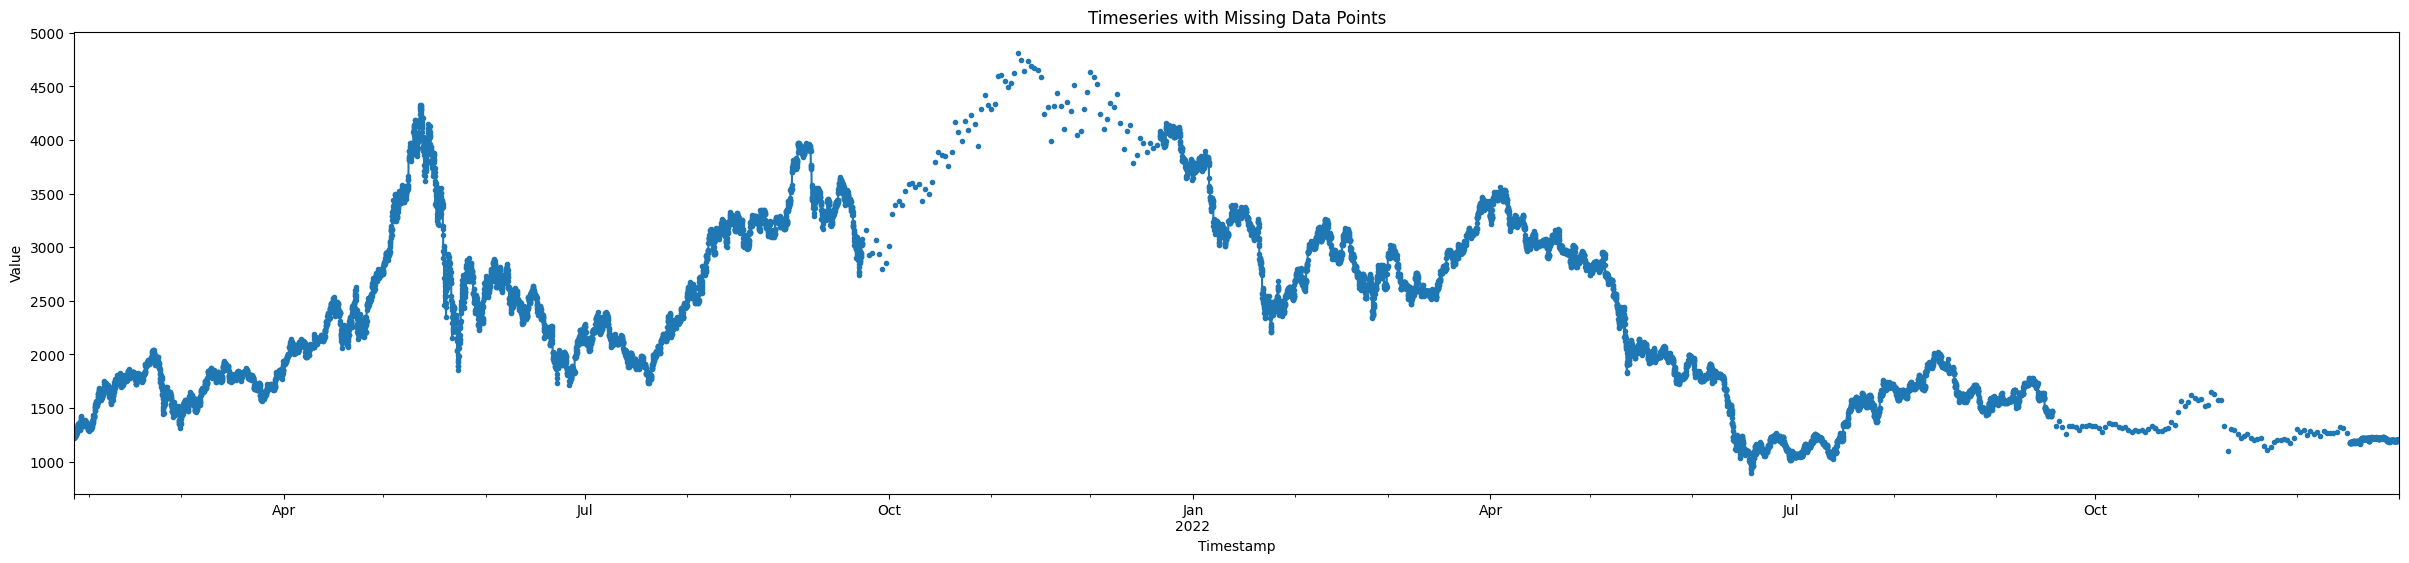

In [138]:
# Create a complete DateTime range
date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')

# Reindex the DataFrame
df_reindexed = data.reindex(date_range)

# Plotting
plt.figure(figsize=(30, 6))
df_reindexed.Ethereum.plot(style='.-')

plt.title('Timeseries with Missing Data Points')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

### Compute and normalize Hourly log-return

In [122]:
hourly_returns_pct = data.pct_change()
hourly_returns_pct = hourly_returns_pct.iloc[1:]
hourly_returns_pct.to_csv("../data/processed/hourly_return.csv")
hourly_log_returns = np.log(hourly_returns_pct + 1)

In [123]:
scaler = StandardScaler()
hourly_log_returns = pd.DataFrame(scaler.fit_transform(hourly_log_returns), columns=hourly_log_returns.columns, index=hourly_log_returns.index)
hourly_log_returns.to_csv("../data/processed/normalized_log_ret.csv")

## Clustering methods

### Louvain (as in class)

In [71]:
def compute_C_minus_C0(lambdas, v, lambda_plus, removeMarketMode=False):
    N=len(lambdas)
    C_clean=np.zeros((N, N))

    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]

    v_m=np.matrix(v)

    # note that the eivenvalues are sorted
    for i in range(1*removeMarketMode,N):
        if lambdas[i]>lambda_plus:
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)
    return C_clean

def LouvainCorrelationClustering(R):   # R is a matrix of return
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2
    C=R.corr()
    lambdas, v = LA.eigh(C)
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    mygraph= nx.from_numpy_array(np.abs(C_s))
    partition = community.community_louvain.best_partition(mygraph, resolution=1.05, random_state=3)
    return partition

### Maximum spanning tree

In [156]:
def mst_clustering(R):
    C = R.corr()
    D = np.sqrt(2*(1-C))
    G = nx.from_numpy_array(D.values)
    return G

In [160]:
mst_clustering(df.set_index('date'))

AttributeError: 'Graph' object has no attribute 'info'

## Rolling window

In [145]:
df = pd.read_csv("../data/processed/normalized_log_ret.csv")

In [146]:
def rename_asset(R, partition):
    dict_cluster = {}
    all_names = list(R.columns)
    for i, name in enumerate(all_names):
        dict_cluster[name]=partition[i]
        
    return dict_cluster

def clustering(R: pd.DataFrame, period: int=720, interval: int = 24, method:str='Louvain') -> dict:
    """Compute the clusters in a rolling window manner for the return matrix R.

    Args:
        R (pd.Dataframe): Normalized log-return matrix
        period (int, optional): time period_. Defaults to 30 days (720 hours).
        interval (int, optional): time interval. Defaults to 1 day (24 hours).
    """
    cluster_dict = {}
    for t0 in tqdm(range(0, len(R.index)-period, interval)):
        R_tmp = R.iloc[t0:t0+period]
        if method == 'Louvain':
            cluster_dict[(t0, t0+period)] = rename_asset(R.set_index('date'), LouvainCorrelationClustering(R_tmp.set_index('date')))
        elif method == 'Likelyhood':
            cluster_dict[(t0, t0+period)] = rename_asset(R.set_index('date'), LouvainCorrelationClustering(R_tmp.set_index('date')))

            
    return cluster_dict
        

In [152]:
aggregate_clusters(df.set_index('date'))

InvalidIndexError: (array([[0],
       [1]]), array([[0, 1]]))